In [1]:
%matplotlib inline

# Introduction to Deep Learning with Keras and TensorFlow

**Daniel Moser (UT Southwestern Medical Center)**

**Resources: [Xavier Snelgrove](https://github.com/wxs/keras-mnist-tutorial), [Yash Katariya](https://github.com/yashk2810/MNIST-Keras)**

To help you understand the fundamentals of deep learning, this demo will walk through the basic steps of building two toy models for classifying handwritten numbers with accuracies surpassing 95%. The first model will be a basic fully-connected neural network, and the second model will be a deeper network that introduces the concepts of convolution and pooling.

## The Task for the AI

Our goal is to construct and train an artificial neural network on thousands of images of handwritten digits so that it may successfully identify others when presented. The data that will be incorporated is the MNIST database which contains 60,000 images for training and 10,000 test images. We will use the Keras Python API with TensorFlow as the backend.

<img src="https://github.com/AviatorMoser/keras-mnist-tutorial/blob/master/mnist.png?raw=1" >

## Prerequisite Python Modules

First, some software needs to be loaded into the Python environment.

In [2]:
import numpy as np                   # advanced math library
import matplotlib.pyplot as plt      # MATLAB like plotting routines
import random                        # for generating random numbers
import tensorflow as tf
import seaborn as sns

from tensorflow.keras.datasets import mnist     # MNIST dataset is included in Keras
from tensorflow.keras.models import Sequential  # Model type to be used

import ann_visualizer.visualize as ann_viz
from tensorflow.keras.layers import Dense, Dropout, Activation # Types of layers to be used in our model
from tensorflow.keras import utils as np_utils                         # NumPy related tools
from sklearn.metrics import confusion_matrix


import datetime

## Visualization
TensorBoard will be used for visualization purposes

In [3]:
%load_ext tensorboard
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tf_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir,histogram_freq=1)

## Loading Training Data

The MNIST dataset is conveniently bundled within Keras, and we can easily analyze some of its features in Python.

In [4]:
# The MNIST data is split between 60,000 28 x 28 pixel training images and 10,000 28 x 28 pixel images
(X_train, y_train), (X_test, y_test) = mnist.load_data()

print("X_train shape", X_train.shape)
print("y_train shape", y_train.shape)
print("X_test shape", X_test.shape)
print("y_test shape", y_test.shape)


X_train shape (60000, 28, 28)
y_train shape (60000,)
X_test shape (10000, 28, 28)
y_test shape (10000,)


Using matplotlib, we can plot some sample images from the training set directly into this Jupyter Notebook.

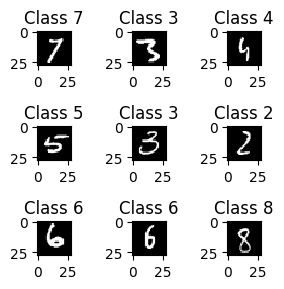

In [5]:
plt.rcParams['figure.figsize'] = (3,3) # Make the figures a bit bigger

for i in range(9):
    plt.subplot(3,3,i+1)
    num = random.randint(0, len(X_train))
    plt.imshow(X_train[num], cmap='gray', interpolation='none')
    plt.title("Class {}".format(y_train[num]))

plt.tight_layout()


Let's examine a single digit a little closer, and print out the array representing the last digit.

In [6]:
# just a little function for pretty printing a matrix
def matprint(mat, fmt="g"):
    col_maxes = [max([len(("{:"+fmt+"}").format(x)) for x in col]) for col in mat.T]
    for x in mat:
        for i, y in enumerate(x):
            print(("{:"+str(col_maxes[i])+fmt+"}").format(y), end="  ")
        print("")

# now print!
matprint(X_train[num])

0  0  0  0  0  0  0  0    0    0    0    0    0    0    0    0    0    0    0    0  0  0  0  0  0  0  0  0  
0  0  0  0  0  0  0  0    0    0    0    0    0    0    0    0    0    0    0    0  0  0  0  0  0  0  0  0  
0  0  0  0  0  0  0  0    0    0    0    0    0    0    0    0    0    0    0    0  0  0  0  0  0  0  0  0  
0  0  0  0  0  0  0  0    0    0    0    0    0    0    0    0    0    0    0    0  0  0  0  0  0  0  0  0  
0  0  0  0  0  0  0  0    0    0    0    0    0    0    0    0    0    0    0    0  0  0  0  0  0  0  0  0  
0  0  0  0  0  0  0  0    0    0    0    0    0    0    0    0    0    0    0    0  0  0  0  0  0  0  0  0  
0  0  0  0  0  0  0  0    0    0    0    0   88  169  211  214  158   46    0    0  0  0  0  0  0  0  0  0  
0  0  0  0  0  0  0  0    0    0   93  211  254  254  254  255  254  206   19    0  0  0  0  0  0  0  0  0  
0  0  0  0  0  0  0  0    0   64  243  254  199   95   52    8   67  254   85    0  0  0  0  0  0  0  0  0  
0  0  0  0  0  0  0

Each pixel is an 8-bit integer from 0-255. 0 is full black, while 255 is full white. This what we call a single-channel pixel. It's called monochrome.

*Fun-fact! Your computer screen has three channels for each pixel: red, green, blue. Each of these channels also likely takes an 8-bit integer. 3 channels -- 24 bits total -- 16,777,216 possible colors!*

## Formatting the input data layer

Instead of a 28 x 28 matrix, we build our network to accept a 784-length vector.

Each image needs to be then reshaped (or flattened) into a vector. We'll also normalize the inputs to be in the range [0-1] rather than [0-255]. Normalizing inputs is generally recommended, so that any additional dimensions (for other network architectures) are of the same scale.

<img src='https://github.com/AviatorMoser/keras-mnist-tutorial/blob/master/flatten.png?raw=1' style="width: 400px; height: 250px;">

In [7]:
X_train = X_train.reshape(60000, 784) # reshape 60,000 28 x 28 matrices into 60,000 784-length vectors.
X_test = X_test.reshape(10000, 784)   # reshape 10,000 28 x 28 matrices into 10,000 784-length vectors.

X_train = X_train.astype('float32')   # change integers to 32-bit floating point numbers
X_test = X_test.astype('float32')

X_train /= 255                        # normalize each value for each pixel for the entire vector for each input
X_test /= 255

print("Training matrix shape", X_train.shape)
print("Testing matrix shape", X_test.shape)

Training matrix shape (60000, 784)
Testing matrix shape (10000, 784)


We then modify our classes (unique digits) to be in the one-hot format, i.e.

```
0 -> [1, 0, 0, 0, 0, 0, 0, 0, 0]
1 -> [0, 1, 0, 0, 0, 0, 0, 0, 0]
2 -> [0, 0, 1, 0, 0, 0, 0, 0, 0]
etc.
```

If the final output of our network is very close to one of these classes, then it is most likely that class. For example, if the final output is:

```
[0, 0.94, 0, 0, 0, 0, 0.06, 0, 0]
```
then it is most probable that the image is that of the digit `1`.

In [8]:
nb_classes = 10 # number of unique digits

Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)

<h3>Building a Multilayer fully connected network (FCN)</h3>

<img src="https://github.com/AviatorMoser/keras-mnist-tutorial/blob/master/figure.png?raw=1" style="width: 300px; height: 300px;"/>

<h3>Build, Train and Test Overview</h3>
Bellow are attributes that you can edit to build your model. TensorBoard will record your training and testing for review after each activity to see how well your model performs. With the attributes we effect various stages in our model train pipeline (compilation, training and testing):

<b>1 Building the model:</b> The model build is the process by which we create its architecture. For this demo, you may define what layers are in the model and the number of neurons in them. The dropout percentage is also available, which will turns neurons off at random - This helps to avoid overfitting. We also choose the hidden layers and output layer's <b>activation function</b> which is the function ran when the neuron activates. Softmax is chosen as the output layer's function as we want probability distributions to determine our answer.

<b>2 Compiling the model:</b> This is where the model <b>optimizer</b>, loss function (aka objective function) and metric (what we'll be using to rate its results) is chosen. 
Catergorical cross entropy is chosen as it results in a probability distribution for our 10 possible digits - i.e. We can be 80% sure its a 3, 10% sure its a 9 and 1% sure its a 4 and so on for example.

The optimizer is what is used to tune how the model learns. It uses an algorithm, known as Gradient Descent to find the optimal value (at a high level this is trying to find the lower values for the loss function for each variable) It requires a learning rate to be provided for it to operate

<img src = "./gradient_descent.png" style="width: 400px; height: 200px">
<img src = "./learning_rate.png" style="width: 400px; height: 200px;">

Choosing a learning rate is important. Large rates could miss the optimal global minimum and small steps could become stuck in local minimum.
<img src = './complicated_loss_function.png' style="width: 400px; height: 200px;">

<b>3 Training (or fitting) the model:</b> This is the main and longest process in our pipeline. This involves using runs to pass through the model and incrementally improve it against the training data we prepared earlier. The runs are called epochs and randomly select data from dataset to train against and the batch size is the ammount of data which is passed through at once (in 'batches')

<b>4 Testing the model:</b> This is the final part of the process and involves comparing what our model got with the ground truth (our Y_test date)

<h3> Build Your Model </h3>
Edit the below variables to configure your model

In [9]:
# Configure your model parameters here

activation_function = 'relu' # Activation function for the hidden layers. Other options include: swish, selu, sigmoid, mish, linear tanh
optimizer = 'adam' # adagrad, adamw, adamax, ftrl, rmsprop 
dropout_perc = 0.2 # Dropout percentage, the random seleciton % of neurons to turn off during training 
batch_size = 128 # Training batch size 
neuron_nums = [512,512] # Pick your no of neurons you want in each layer
epoch_num = 5
## Example of a really bad case

# # Configure your model parameters here
# activation_function = 'sigmoid' # Activation function for the hidden layers. Other options include: swish, selu, sigmoid, mish, linear tanh
# optimizer = 'adagrad' # adagrad, adamw, adamax, ftrl, rmsprop 
# dropout_perc = 0.6 # Dropout percentage, the random seleciton % of neurons to turn off during training 
# batch_size = 254 # Training batch size 
# neuron_nums = [512,512,512] # Pick your no of neurons you want in each layer
# epoch_num = 5


In [10]:
# The Sequential model is a linear stack of layers and is very common.
model = Sequential()

def build_model(activation_function,dropout_perc,neuron_nums):
    # The first hidden layer is a set of 512 nodes (artificial neurons).
    # Each node will receive an element from each input vector and apply some weight and bias to it.
    model.add(Dense(512, input_shape=(784,))) #(784,) is not a typo -- that represents a 784 length vector!
    
    # An "activation" is a non-linear function applied to the output of the layer above.
    # It checks the new value of the node, and decides whether that artifical neuron has fired.
    # The Rectified Linear Unit (ReLU) converts all negative inputs to nodes in the next layer to be zero.
    # Those inputs are then not considered to be fired.
    # Positive values of a node are unchanged.
    model.add(Activation(activation_function))
    
    # Dropout zeroes a selection of random outputs (i.e., disables their activation)
    # Dropout helps protect the model from memorizing or "overfitting" the training data.
    model.add(Dropout(dropout_perc))
    
    # The following hidden layers appear identical to our first layer.
    # However, instead of each of the 512-node receiving 784-inputs from the input image data,
    # they receive previous outputs as inputs for themselves.    
    for num in neuron_nums:    
        model.add(Dense(num))
        model.add(Activation(activation_function))
        model.add(Dropout(dropout_perc))
    
    # The final layer of 10 neurons in fully-connected to the previous 512-node layer.
    # The final layer of a FCN should be equal to the number of desired classes (10 in this case).
    model.add(Dense(10))
    
    model.add(Activation('softmax'))
    print('------ Model Built: \n')
    model.summary()

def compile_model(optimizer):
    # Let's use the Adam optimizer for learning
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    print('------ Model Compiled with Optimizer: ', optimizer)

def train_model(X_train, Y_train, batch_size, epoch_num):
    print('------ Model Training: \n')
    model.fit(X_train, Y_train,
          batch_size=batch_size, epochs=epoch_num,
          verbose=1,callbacks=[tf_callback])


build_model(activation_function,dropout_perc,neuron_nums)
compile_model(optimizer=optimizer)
train_model(X_train,Y_train, batch_size, epoch_num)

------ Model Built: 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               401920    
                                                                 
 activation (Activation)     (None, 512)               0         
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 512)               262656    
                                                                 
 activation_1 (Activation)   (None, 512)               0         
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None

In [12]:
%tensorboard --logdir log_dir

Reusing TensorBoard on port 6006 (pid 39920), started 1:34:49 ago. (Use '!kill 39920' to kill it.)

<h3>Testing the Model</h3>

In [13]:
!kill 39920

'kill' is not recognized as an internal or external command,
operable program or batch file.


In [14]:
score = model.evaluate(X_test, Y_test)
print('Test score:', score[0])
print('Test accuracy:', score[1])

313/313 [==============================] - 2s 4ms/step - loss: 2.3013 - accuracy: 0.1135
Test score: 2.3013434410095215
Test accuracy: 0.11349999904632568


<h3> Where Did We Go Wrong?! </h3>
It's always a good idea to inspect the output and make sure everything looks sane. Here we'll look at some examples it gets right, and some examples it gets wrong. We use a confusion matrix to summarize how we did in solving out dataset.

In [15]:
# The predict_classes function outputs the highest probability class
# according to the trained classifier for each input example.
predicted_classes = model.predict(X_test)

# Check which items we got right / wrong
correct_indices = np.nonzero(np.argmax(predicted_classes, axis=1) == y_test)[0]
incorrect_indices = np.nonzero(np.argmax(predicted_classes, axis=1) != y_test)[0]
print('Amount Predicted Correctly: ' + str(len(correct_indices)), '\nAmount Predicted Incorrectly: ' + str(len(incorrect_indices)))

313/313 [==============================] - 1s 4ms/step
Amount Predicted Correctly: 1135 
Amount Predicted Incorrectly: 8865


Text(0.5, 1.0, 'Confusion Matrix')

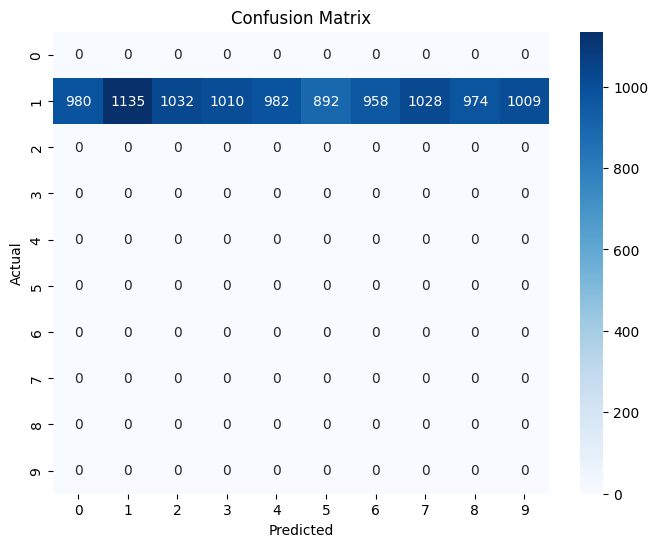

In [16]:
cm = confusion_matrix(np.argmax(predicted_classes, axis=1),y_test)
# Plot the confusion matrix as a heatmap using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
